# Function encoders with neural ODE basis functions
The function encoder is agnostic to the basis function, so long as it is differentiable. Consequently, the basis function architecture can be modified to fit the problem at hand. For example, for continuous-time systems, the best models are typically neural ODEs. Neural ODEs output the gradient of the system, and then integrate it to get the next state, rather than outputing the next state directly:

$$
x_t = x_0 + \int_0^t f(x_\tau ; \theta) d\tau
$$

This is extremely accurate because the inductive bias of this model matches the continuous-time nature of the dynamical system. However, neural ODEs are slow to train, and cannot adapt to new data at runtime. We can fix this by combining neural ODEs with function encoders. As we saw in the first example, function encoders can adapt their model estimates based on small amounts of data. By combining the two approaches, we get the best of both worlds: Accurate, continuous-time estimates AND efficient, online model updates. All this requires is to define the basis functions as neural ODEs instead of neural networks. The algorithm is unchanged.

We will demonstrate this on a simple Van Der Pol system, modeled with a simple RK4 integrator. 

In [1]:
import torch
import matplotlib.pyplot as plt

from neuromancer.dataset import DictDataset
from neuromancer.dynamics import integrators
from neuromancer.dynamics.integrators import Integrator
from neuromancer.modules import blocks
from neuromancer.system import Node
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from tqdm import trange

from FunctionEncoder import FunctionEncoder

def vanderpol(state, mu):
    """The Van Der Pol mapping from x to \dot x for a given value \mu. """
    x1 = state[..., 0]
    x2 = state[..., 1]
    dx1 = x2
    dx2 = mu * (1 - x1 ** 2) * x2 - x1
    return torch.stack([dx1, dx2], dim=-1)

def rk4_delta_only(model, state, dt):
    """
    Integrate a model using the 4th order Runge-Kutta method.
    :param model: a callable mapping from x to \dot x
    :param state: The initial state
    :param dt:  The time horizon
    :return: Delta X, the change in state
    """
    k1 = model(state)
    k2 = model(state + dt / 2 * k1)
    k3 = model(state + dt / 2 * k2)
    k4 = model(state + dt * k3)
    return dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

Next, let's create some datasets. There is a design choice we can make here. We can either sample random states, and integrate them for a full trajectory, or we can integrate them for a single timestep. Integrating a full trajectory is a more realistic setting, but is also more challenging. Because Van Der Pol has an attractor, most of the data will end up at the attractor. Consequently, our data will be sparse elsewhere, and the learned model will be less accurate away from the attractor. In either case, we will still evaluate on full trajectory rollouts.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dt = 0.05
def create_dataset(device='cpu', generate_trajectory = False):

    # hyper parameters
    n_functions = 1000


    # input space for sampling
    input_low = torch.tensor([-4., -4.], device=device)
    input_high = torch.tensor([4., 4.], device=device)
    mu_range = torch.tensor([0.1, 3.], device=device)

    # samples dynamical systems
    mus = torch.rand(n_functions, 1, device=device) * (mu_range[1] - mu_range[0]) + mu_range[0]

    # we can generate a series of trajectories with different values of mu.
    # However, this makes the problems harder because Van Der Pol specifcally has an attractor
    # this means the states will not be evenly distributed throughout the input space.
    if generate_trajectory:
        time_horizon = 1000
        # Generate a trajectory of example data for each mu
        initial_states = torch.rand(n_functions, 1, 2, device=device) * (input_high - input_low) + input_low
        example_states = [initial_states]
        for i in range(time_horizon):
            current_state = example_states[-1]
            delta_X = rk4_delta_only(lambda x: vanderpol(x, mus), current_state, dt)
            new_state = current_state + delta_X
            example_states.append(new_state)
        example_states = torch.cat(example_states, dim=1)

        # Generate a trajectory of query data for each mu
        initial_states = torch.rand(n_functions, 1, 2, device=device) * (input_high - input_low) + input_low
        query_states = [initial_states]
        for i in range(time_horizon):
            current_state = query_states[-1]
            delta_X = rk4_delta_only(lambda x: vanderpol(x, mus), current_state, dt)
            new_state = current_state + delta_X
            query_states.append(new_state)
        query_states = torch.cat(query_states, dim=1)

        # now create the dataset for the function encoder. The input is a state x, the output is the delta x
        example_xs = example_states[:, :-1, :]
        example_delta_xs = example_states[:, 1:, :] - example_states[:, :-1, :]
        query_xs = query_states[:, :-1, :]
        delta_xs = query_states[:, 1:, :] - query_states[:, :-1, :]


        dataset = {"example_xs": example_xs.to(device),
                    "example_ys": example_delta_xs.to(device),
                    "query_xs": query_xs.to(device),
                    "query_ys": delta_xs.to(device),
                    "mu": mus.to(device),  # NOTE: mu is only used for plotting.
                    }
    else:
        # samples uniformly from the input space, then takes one step
        n_datapoints = 1000
        # Generate a trajectory of example data for each mu
        example_xs = torch.rand(n_functions, n_datapoints, 2, device=device) * (input_high - input_low) + input_low
        query_xs = torch.rand(n_functions, n_datapoints, 2, device=device) * (input_high - input_low) + input_low

        # compute next state
        example_ys = rk4_delta_only(lambda x: vanderpol(x, mus), example_xs, dt)
        query_ys = rk4_delta_only(lambda x: vanderpol(x, mus), query_xs, dt)

        dataset = {"example_xs": example_xs,
                   "example_ys": example_ys,
                   "query_xs": query_xs,
                   "query_ys": query_ys,
                   "mu": mus.to(device),  # NOTE: mu is only used for plotting.
                   }

    return dataset

# Create dataset
train_dataset = create_dataset(device, generate_trajectory=False) # Change this to True for a harder setting!
test_dataset = create_dataset(device, generate_trajectory=True)

As is usual, let's wrap these for NeuroMancer:

In [3]:
# Wrap data into Neuromancer DictDatasets
train_data = DictDataset(train_dataset, name='train')
dev_data = DictDataset(test_dataset, name='dev')

# Create torch dataloaders with DictDatasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=10,
                                         collate_fn=dev_data.collate_fn,
                                         shuffle=False)

Next, let's define the basis functions. Again, we will use RK4 as the integrator. One important detail is that this integrator outputs the CHANGE in state, rather than the next state directly. This is a more convenient form for the function encoder. For the sake of brevity, I won't go into it here, but see ["Zero-Shot Transfer of Neural ODEs" (NeurIPS 2024)](https://arxiv.org/abs/2405.08954) if you are curious about these details.


In [4]:
# Initialize basis functions networks
n_basis = 11
basis_functions = [
    blocks.MLP(2, 2,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[100]).to(device)
    for i in range(n_basis)]

# use an integrator to make them neural ODEs
# Note this integrator outputs the change in state, not the next state
class RK4_delta_only(Integrator):
    def __init__(self, block, interp_u=None, h=1.0):
        """

        :param block: (nn.Module) A state transition model.
        :param h: (float) integration step size
        """
        super().__init__(block=block, interp_u=interp_u, h=h)

    def integrate(self, x, *args):
        h = self.h
        k1 = self.block(x, *args)                    # k1 = f(x_i, t_i)
        k2 = self.block(x + h*k1/2.0, *args)         # k2 = f(x_i + 0.5*h*k1, t_i + 0.5*h)
        k3 = self.block(x + h*k2/2.0, *args)         # k3 = f(x_i + 0.5*h*k2, t_i + 0.5*h)
        k4 = self.block(x + h*k3, *args)             # k4 = f(y_i + h*k3, t_i + h)
        return h*(k1/6.0 + k2/3.0 + k3/3.0 + k4/6.0)
basis_functions = [RK4_delta_only(f, h=dt) for f in basis_functions]

# the function encoder class provides convenient methods to calibrate estimates using least squares
# specifically, it uses example data to compute the coefficients of the basis functions,
# then uses a linear combination of the basis functions to estimate the function
function_encoder = FunctionEncoder(basis_functions)

Let's also wrap the function encoder into the neuromancer interface.

In [5]:
# Symbolic wrapper of the neural nets
function_encoder = Node(function_encoder, ['example_xs', 'example_ys', 'query_xs'], ['query_y_hats', 'gram'], name='function_encoder')

# Define symbolic variables in Neuromancer
# these are the variables used in the loss functions
query_y_hats = variable('query_y_hats')
query_ys = variable('query_ys')
gram = variable('gram')

Next, let's define the loss function. These are exactly the same as in the previous example. 

In [6]:
# Define the losses
# The first ensures the function estimates align with the true function
loss_data = (query_y_hats == query_ys)^2
loss_data.name = "loss_data"

# this prevents the magnitude of the basis functions from growing
loss_gram = (torch.diagonal(gram, dim1=1, dim2=2) == torch.ones_like(torch.diagonal(gram, dim1=1, dim2=2)))^2
loss_gram.name = "loss_gram"

# add the two losses together
loss = PenaltyLoss(objectives=[loss_data, loss_gram], constraints=[])

Now we are ready to train. Note that this is going to take a few minutes because there are many neural ODEs being run in sequence. In practice, these are run in parallel which greatly speeds things up at the cost of memory.

In [7]:
# Construct the optimization problems
problem = Problem(nodes=[function_encoder], loss=loss)


# Create trainer
num_epochs = 200
trainer = Trainer(
    problem.to(device),
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer=torch.optim.Adam(problem.parameters(), lr=1e-3),
    epoch_verbose=10,
    epochs=num_epochs,
    warmup=num_epochs,
    device=device,
)


# Train function encoder
best_model = trainer.train()

epoch: 0  train_loss: 1.0049488544464111
epoch: 10  train_loss: 0.003762350883334875
epoch: 20  train_loss: 0.0022456387523561716
epoch: 30  train_loss: 0.0014202480670064688
epoch: 40  train_loss: 0.0010459391633048654
epoch: 50  train_loss: 0.0007996392669156194
epoch: 60  train_loss: 0.0006280817906372249
epoch: 70  train_loss: 0.0005025389255024493
epoch: 80  train_loss: 0.00040542034548707306
epoch: 90  train_loss: 0.0003328899329062551
epoch: 100  train_loss: 0.0002780744689516723
epoch: 110  train_loss: 0.0002342964435229078
epoch: 120  train_loss: 0.0001982129324460402
epoch: 130  train_loss: 0.000168472935911268
epoch: 140  train_loss: 0.00014391135482583195
epoch: 150  train_loss: 0.00012363043788354844
epoch: 160  train_loss: 0.00010673716315068305
epoch: 170  train_loss: 9.273495379602537e-05
epoch: 180  train_loss: 8.097620593616739e-05
epoch: 190  train_loss: 7.111204467946663e-05


Let's plot the result:

Rolling out trajectory: 100%|██████████| 999/999 [00:01<00:00, 567.55it/s]


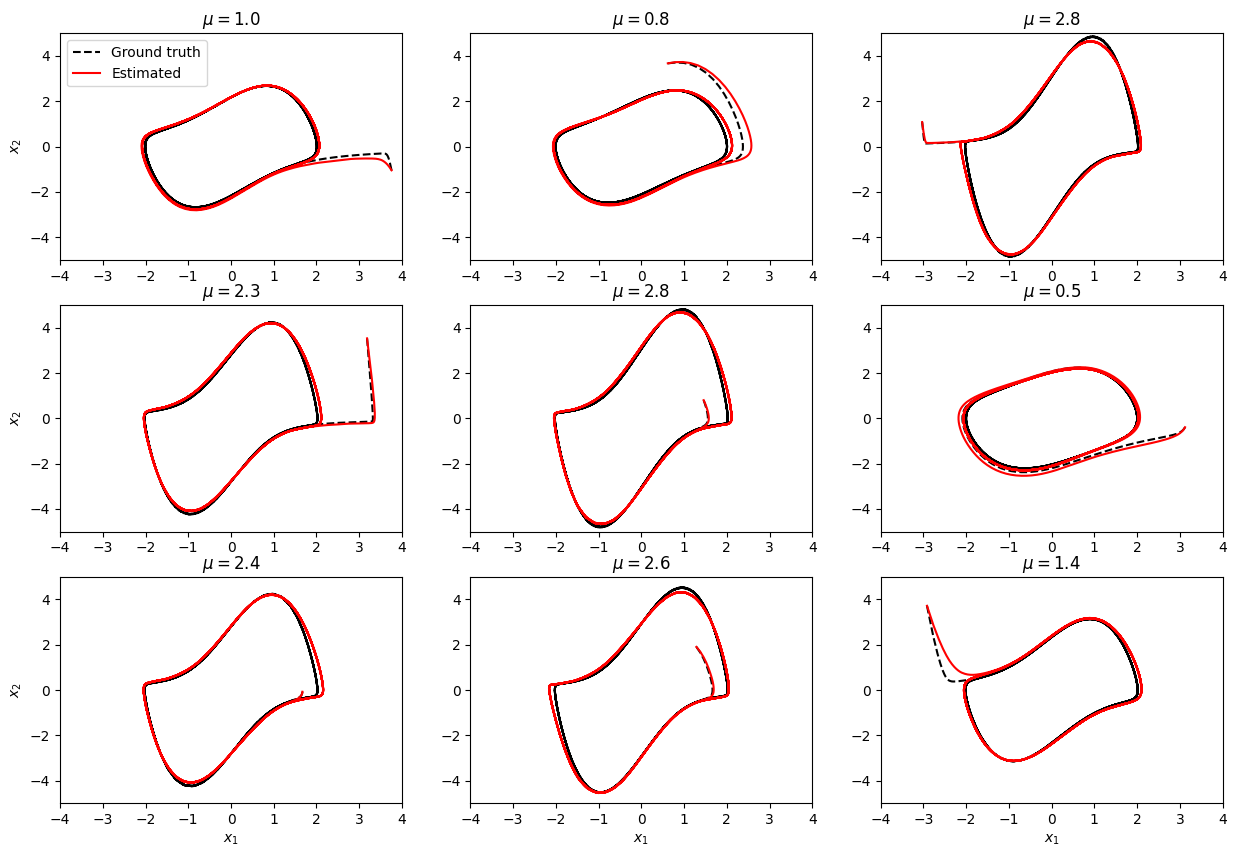

In [9]:
# # get best model
problem.load_state_dict(best_model)
trained_model = problem.nodes[0]
trained_model = trained_model.callable

# estimate outputs and plot.
with torch.no_grad():
    example_xs, example_ys, query_xs, query_ys, mus = test_dataset["example_xs"], test_dataset["example_ys"], test_dataset["query_xs"], test_dataset["query_ys"], test_dataset["mu"]
    fig, axs = plt.subplots(3,3, figsize=(15,10))
    coefficients, gram = trained_model.compute_representation(example_xs, example_ys)

    # rollout a trajectory starting from the first query xs for each environment
    estimated_states = [query_xs[:, 0:1, :]]
    for i in trange(1, query_xs.shape[1], desc="Rolling out trajectory"):
        current_state = estimated_states[-1]
        delta_X = trained_model.predict(current_state, coefficients)
        new_state = current_state + delta_X
        estimated_states.append(new_state)
    estimated_states = torch.cat(estimated_states, dim=1)


    for i in range(9):
        ax = axs[i//3, i%3]
        # plot the ground truth van der pol
        ax.plot(query_xs[i, :, 0].cpu().numpy(), query_xs[i, :, 1].cpu().numpy(), label="Ground truth", color="black", ls="--")

        # plot the estimated van der pol
        ax.plot(estimated_states[i, :, 0].cpu().numpy(), estimated_states[i, :, 1].cpu().numpy(), label="Estimated", color="red")

        # add labels
        if i == 0:
            ax.legend()
        if i % 3 == 0:
            ax.set_ylabel("$x_2$")
        if i // 3 == 2:
            ax.set_xlabel("$x_1$")

        # add mu as title
        mu = mus[i].cpu().item()
        ax.set_title(f"$\mu = {mu:.1f}$")

        # set lims
        ax.set_xlim([-4, 4])
        ax.set_ylim([-5, 5])
